This tutorial is about
- Global constants in quantax
- Define Symmetry
- Define Ising Hamiltonian
- Exact diagonalization
- Define RBM neural quantum state
- Exact reconfiguration
- Stochastic reconfiguration (TDVP)

In [1]:
import numpy as np
import jax.numpy as jnp
import quantax as qtx

# ======================= Global constants in quantax =======================
# random seed, default to 0
qtx.set_random_seed(2347)

# default data types for computations outside variational ansatz, default to float64
qtx.set_default_dtype(jnp.float64)

# lattice of quantum systems, MUST be given in the beginning of the program
# lattice is treated as a GLOBAL CONSTANT implicitly passed to other quantities
# DON'T define different lattices in a single run
lattice = qtx.sites.Chain(12) # default to periodic boundaries

In [2]:
# Ising hamiltonian with transverse field h=1
H = qtx.operator.Ising(h=1)

# an alternative way to define the Ising hamiltonian

from quantax.operator import sigma_z, sigma_x

L = lattice.N
h = 1
# periodic boundary is assumed
H = -sum(sigma_z(i) * sigma_z(i+1) for i in range(L))
H -= sum(h * sigma_x(i) for i in range(L))

In [3]:
from quantax.symmetry import Trans1D, SpinInverse, Flip

# combination of symmetries can be done by a summation
symm = Trans1D() + SpinInverse() + Flip()

# diagonalize H in the given symmetry sector and obtain the 3 lowest eigenstates
E, wave_function = H.diagonalize(symm=symm, k=3)
print(E)

# construct a dense state given the ground state wave function
dense = qtx.state.DenseState(wave_function[:, 0], symm=symm)

# compute <dense|H|dense>, verify the ground state energy
energy = dense @ H @ dense
assert np.isclose(energy, E[0])

# `GeneralBasisWarning` is because Trans1D and Flip don't commute with each other.

/home/chenao/quantax_env/lib/python3.12/site-packages/quantax/symmetry/symmetry.py:268: GeneralBasisWarning: using non-commuting symmetries can lead to unwanted behaviour of general basis, make sure that quantum numbers are invariant under non-commuting symmetries!
  basis = spin_basis_general(self.N, Nup, pauli=0, make_basis=False, **blocks)


[-15.32259515 -14.27838561 -12.26112769]


In [4]:
# RBM wave function with alpha=4
model = qtx.model.RBM_Dense(features=4*L)

# define the variational state with given symmetry projection
state = qtx.state.Variational(model=model, symm=symm)

# define exact reconfiguration optimizer
# this is only for tests in small systems where the full wave function can be obtained
optimizer = qtx.optimizer.ER(state, H, symm=symm)

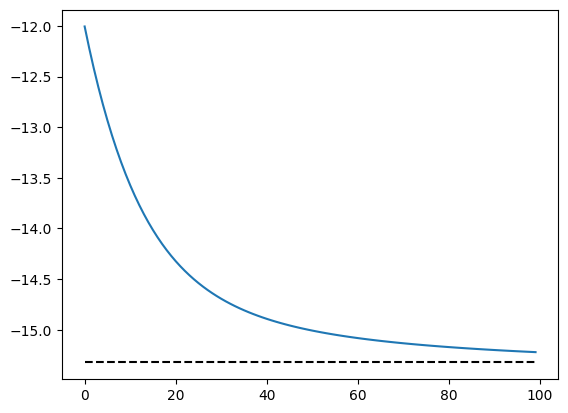

In [5]:
# a data tracer for recording the energy
energy_data = qtx.utils.DataTracer()

# optimization iterations
for i in range(100):
    step = optimizer.get_step()
    state.update(step * 1e-2) # step size 1e-2
    energy_data.append(optimizer.energy)

energy_data.plot(baseline=E[0])

In [6]:
# variational energies can also be computed exactly in small systems

state_dense = state.todense(symm).normalize()
# E = <psi|H|psi>
variational_energy = state_dense @ H @ state_dense
print(variational_energy)

-15.222630290052567


In [7]:
# define a new variational state
model = qtx.model.RBM_Dense(features=4*L)
state = qtx.state.Variational(model=model, symm=symm)

# sampler with local flip updates
sampler = qtx.sampler.LocalFlip(state, nsamples=1000)

# stochastic reconfiguration optimizer, which can work in most cases
optimizer = qtx.optimizer.SR(state, H)

E0715 00:15:17.700038  119293 hlo_lexer.cc:444] Failed to parse int literal: 073633466920384733389
E0715 00:15:17.700064  119293 hlo_lexer.cc:444] Failed to parse int literal: 073633466920384733389


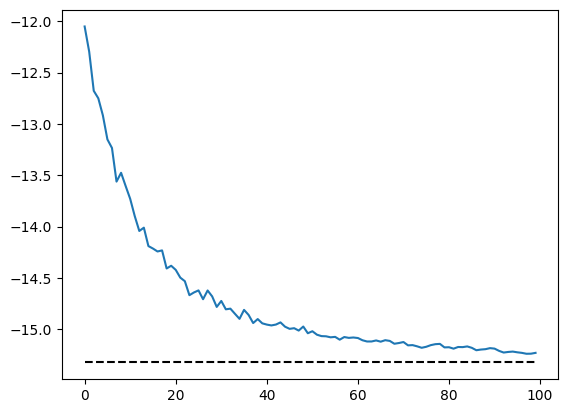

In [8]:
energy_data = qtx.utils.DataTracer()

# optimization iterations, now requires sampling
for i in range(100):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    state.update(step * 1e-2)
    energy_data.append(optimizer.energy)

energy_data.plot(baseline=E[0])